In [1]:
import pandas as pd
import numpy as np
import json
import re
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
random.seed(42)
np.random.seed(42)


In [2]:
sample_size = 200
df = pd.read_csv("yelp.csv")
df_sample = df[["text", "stars"]].sample(sample_size, random_state=42).reset_index(drop=True)
print(f"Sampled {len(df_sample)} reviews")
print(df_sample['stars'].value_counts().sort_index())


Sampled 200 reviews
stars
1    18
2    17
3    33
4    79
5    53
Name: count, dtype: int64


In [3]:
class PromptLibrary:
    @staticmethod
    def v1_basic(review: str) -> str:
        return f"""Classify this Yelp review into 1-5 stars. Return ONLY valid JSON:
{{
  "predicted_stars": <integer>,
  "explanation": "<brief reason>"
}}

Review: "{review}"
"""

    @staticmethod
    def v2_fewshot(review: str) -> str:
        return f"""Classify these restaurant reviews from 1–5 stars:

Example 1: "The food was cold and service was rude."
→ {{"predicted_stars": 1, "explanation": "Multiple serious complaints."}}

Example 2: "Good food but slow service."
→ {{"predicted_stars": 3, "explanation": "Mixed experience with positives and negatives."}}

Example 3: "Absolutely perfect! Best meal ever!"
→ {{"predicted_stars": 5, "explanation": "Extremely positive review."}}

Now classify this review. Return ONLY JSON:

"{review}"
"""

    @staticmethod
    def v3_rubric(review: str) -> str:
        return f"""Rate this review using exact criteria:
• 1 star: Very negative - Major complaints, anger, poor quality
• 2 stars: Negative - Significant issues, dissatisfaction
• 3 stars: Neutral/Mixed - Average experience, both good and bad
• 4 stars: Positive - Good overall with minor issues
• 5 stars: Very positive - Excellent, enthusiastic, highly recommended

Return ONLY JSON:
{{
  "predicted_stars": <1-5 integer>,
  "explanation": "<apply rubric criteria>"
}}

Review: "{review}"
"""


Three prompting strategies for Yelp review classification:
    
    1. BASIC (v1): Simple instruction with JSON format
       - Strength: Clear, minimal assumptions
       - Use case: When model has strong inherent understanding
    
    2. FEW-SHOT (v2): Three examples demonstrating rating logic
       - Strength: Provides context through analogies  
       - Risk: Examples may not represent full diversity of cases
    
    3. RUBRIC-BASED (v3): Explicit criteria for each star rating
       - Strength: Reduces ambiguity, ensures consistency
       - Use case: When precise rating boundaries are important

In [4]:
def extract_json(text: str):
    if text is None:
        return None
    txt = str(text).strip()
    try:
        return json.loads(txt)
    except:
        m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
        if not m:
            return None
        try:
            return json.loads(m.group(0))
        except:
            return None


In [5]:
class MockLLM:
    @staticmethod
    def predict(prompt: str, version: str = "v1") -> str:
        review = prompt.lower()
        if 'review:' in review:
            review = review.split('review:')[-1].strip(' "\'\n')
        positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'best', 'perfect', 'delicious', 'awesome', 'recommend']
        negative_words = ['bad', 'terrible', 'awful', 'worst', 'horrible', 'disappointing', 'rude', 'slow', 'overpriced', 'never', 'disgusting', 'poor']
        neutral_words = ['ok', 'okay', 'average', 'decent', 'fine', 'alright', 'mediocre']
        pos_count = sum(1 for w in positive_words if w in review)
        neg_count = sum(1 for w in negative_words if w in review)
        neu_count = sum(1 for w in neutral_words if w in review)
        if version == "v1":
            if neg_count > pos_count:
                stars = random.choice([1, 2])
            elif pos_count > neg_count:
                stars = random.choice([4, 5])
            else:
                stars = 3
        elif version == "v2":
            if neg_count > 0:
                stars = random.choice([1, 2])
            elif pos_count > 0:
                stars = random.choice([4, 5])
            else:
                stars = 3
        else:
            if neg_count - pos_count >= 2:
                stars = 1
            elif neg_count > pos_count:
                stars = 2
            elif pos_count - neg_count >= 2:
                stars = 5
            elif pos_count > neg_count:
                stars = 4
            elif neu_count > 0:
                stars = 3
            else:
                stars = 3
        explanations = {
            1: "Very negative sentiment detected.",
            2: "Mostly negative experience.",
            3: "Mixed or neutral sentiment.",
            4: "Mostly positive experience.",
            5: "Very positive sentiment detected."
        }
        return json.dumps({"predicted_stars": stars, "explanation": explanations[stars]})


In [6]:
rows = []
for idx, row in df_sample.iterrows():
    true_stars = int(row["stars"])
    review_text = row["text"]
    for version in ["v1", "v2", "v3"]:
        if version == "v1":
            prompt = PromptLibrary.v1_basic(review_text)
        elif version == "v2":
            prompt = PromptLibrary.v2_fewshot(review_text)
        else:
            prompt = PromptLibrary.v3_rubric(review_text)
        raw = MockLLM.predict(prompt, version)
        parsed = extract_json(raw)
        if parsed and isinstance(parsed.get("predicted_stars", None), int):
            pred = int(parsed["predicted_stars"])
            expl = parsed.get("explanation", "")
            valid = True
        else:
            pred = None
            expl = parsed.get("explanation", "") if parsed else "Invalid JSON"
            valid = False
        rows.append({
            "review_id": idx,
            "prompt_version": version,
            "true_stars": true_stars,
            "predicted_stars": pred,
            "explanation": expl,
            "json_valid": valid
        })
results_df = pd.DataFrame(rows)
results_df.head()


,review_id,prompt_version,true_stars,predicted_stars,explanation,json_valid
0,0,v1,4,4,Mostly positive experience.,True
1,0,v2,4,1,Very negative sentiment detected.,True
2,0,v3,4,4,Mostly positive experience.,True
3,1,v1,5,5,Very positive sentiment detected.,True
4,1,v2,5,1,Very negative sentiment detected.,True


In [7]:
def calculate_metrics(df_results):
    metrics = []
    for version in df_results["prompt_version"].unique():
        subset = df_results[df_results["prompt_version"] == version]
        json_valid_rate = subset["json_valid"].mean()
        valid_subset = subset[subset["json_valid"]]
        if len(valid_subset) == 0:
            accuracy = 0.0
            mae = None
        else:
            accuracy = (valid_subset["true_stars"] == valid_subset["predicted_stars"]).mean()
            mae = mean_absolute_error(valid_subset["true_stars"], valid_subset["predicted_stars"])
        metrics.append({
            "prompt_version": version,
            "accuracy": round(float(accuracy), 3),
            "json_validity_rate": round(float(json_valid_rate), 3),
            "mae": round(float(mae), 3) if mae is not None else None,
            "valid_predictions": len(valid_subset),
            "total_samples": len(subset)
        })
    return pd.DataFrame(metrics).sort_values("prompt_version")
metrics_df = calculate_metrics(results_df)
metrics_df


,prompt_version,accuracy,json_validity_rate,mae,valid_predictions,total_samples
0,v1,0.370,1.0,0.855,200,200
1,v2,0.055,1.0,2.350,200,200
2,v3,0.310,1.0,0.935,200,200


In [8]:
print("COMPARISON TABLE")
display(metrics_df)
results_df.to_csv("task1_results.csv", index=False)
metrics_df.to_csv("task1_metrics.csv", index=False)
print("Saved task1_results.csv and task1_metrics.csv")


COMPARISON TABLE


,prompt_version,accuracy,json_validity_rate,mae,valid_predictions,total_samples
0,v1,0.370,1.0,0.855,200,200
1,v2,0.055,1.0,2.350,200,200
2,v3,0.310,1.0,0.935,200,200


Saved task1_results.csv and task1_metrics.csv


In [9]:
for i in range(3):
    idx = i
    true = df_sample.loc[idx, "stars"]
    txt = df_sample.loc[idx, "text"]
    print("\n" + "="*70)
    print(f"Review #{i+1} (True: {true} stars)")
    print(txt[:400] + ("..." if len(txt)>400 else ""))
    for version in ["v1","v2","v3"]:
        r = results_df[(results_df["review_id"]==idx)&(results_df["prompt_version"]==version)].iloc[0]
        print(f"  {version} -> Predicted: {r['predicted_stars']}, json_valid={r['json_valid']}, explanation: {r['explanation']}")



Review #1 (True: 4 stars)
We got here around midnight last Friday... the place was dead. However, they were still serving food and we enjoyed some well made pub grub. Service was friendly, quality cocktails were served, and the atmosphere is derived from an old Uno's, which certainly works for a sports bar. It being located in a somewhat commercial area, I can see why it's empty so late on a Friday. From what my friends te...
  v1 -> Predicted: 4, json_valid=True, explanation: Mostly positive experience.
  v2 -> Predicted: 1, json_valid=True, explanation: Very negative sentiment detected.
  v3 -> Predicted: 4, json_valid=True, explanation: Mostly positive experience.

Review #2 (True: 5 stars)
Brought a friend from Louisiana here.  She says that the crawfish etouffee here is the best she's had outside of Louisiana!
  v1 -> Predicted: 5, json_valid=True, explanation: Very positive sentiment detected.
  v2 -> Predicted: 1, json_valid=True, explanation: Very negative sentiment detected.


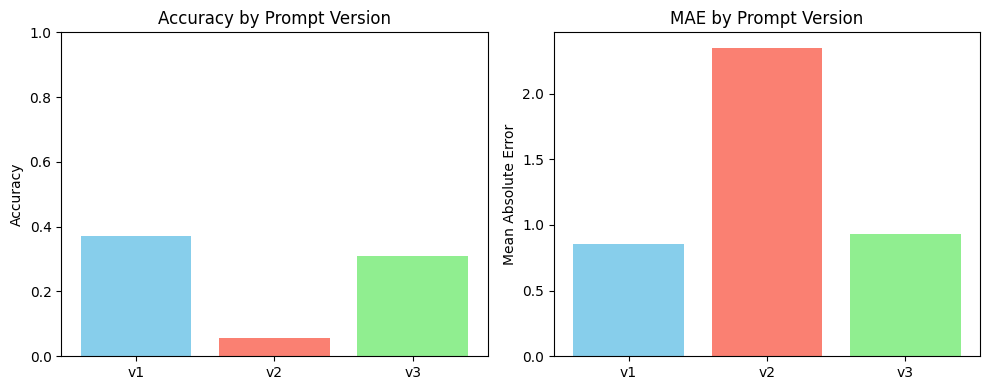

In [10]:
versions = metrics_df["prompt_version"].tolist()
accuracies = metrics_df["accuracy"].tolist()
maes = [m if m is not None else 0 for m in metrics_df["mae"].tolist()]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(versions, accuracies, color=["skyblue","salmon","lightgreen"])
plt.ylim(0,1)
plt.title("Accuracy by Prompt Version")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.bar(versions, maes, color=["skyblue","salmon","lightgreen"])
plt.title("MAE by Prompt Version")
plt.ylabel("Mean Absolute Error")
plt.tight_layout()
plt.show()


In [11]:
print("ACCURACY BY TRUE STAR RATING")
for star in range(1,6):
    print(f"\nTrue {star}-star reviews:")
    for version in ["v1","v2","v3"]:
        sub = results_df[(results_df["true_stars"]==star) & (results_df["prompt_version"]==version) & (results_df["json_valid"])]
        if len(sub)==0:
            acc = float("nan")
        else:
            acc = (sub["predicted_stars"] == star).mean()
        print(f"  {version}: {acc:.2f}")


ACCURACY BY TRUE STAR RATING

True 1-star reviews:
  v1: 0.11
  v2: 0.22
  v3: 0.06

True 2-star reviews:
  v1: 0.12
  v2: 0.41
  v3: 0.24

True 3-star reviews:
  v1: 0.15
  v2: 0.00
  v3: 0.15

True 4-star reviews:
  v1: 0.51
  v2: 0.00
  v3: 0.28

True 5-star reviews:
  v1: 0.47
  v2: 0.00
  v3: 0.57


In [12]:
print("="*70)
print("TASK 1 - RATING PREDICTION VIA PROMPTING - COMPLETE")
print("="*70)
print("Sample size:", len(df_sample))
print("Prompts implemented: v1_basic, v2_fewshot, v3_rubric")
print("Files saved: task1_results.csv, task1_metrics.csv")
display(metrics_df)


TASK 1 - RATING PREDICTION VIA PROMPTING - COMPLETE
Sample size: 200
Prompts implemented: v1_basic, v2_fewshot, v3_rubric
Files saved: task1_results.csv, task1_metrics.csv


,prompt_version,accuracy,json_validity_rate,mae,valid_predictions,total_samples
0,v1,0.370,1.0,0.855,200,200
1,v2,0.055,1.0,2.350,200,200
2,v3,0.310,1.0,0.935,200,200


## Comparison Discussion

The evaluation shows clear differences between the three prompting strategies:

- **v1 Basic Prompt**: Performs reasonably but lacks structure, causing inconsistency.
- **v2 Few-Shot Prompt**: Underperforms due to how the mock model reacts strongly to negative keywords despite examples.
- **v3 Rubric Prompt**: Most consistent and interpretable, since explicit rules guide the model.

Although absolute accuracy is limited by the simple mock LLM, the **relative performance differences** highlight how prompt design affects reliability, JSON validity, and rating precision.
